This notebook is for presentation only

# 1. Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from DataPipe import DataPipe

# Suppress warnings related to DataFrame concatenation
warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries")

# 2. Create `Analysis` Class

In [2]:
class Analysis:
    """
    This class processes neuroimaging and behavioral data, 
    runs linear regression, computes p-values, and visualizes 
    top predictive features for CUDIT scores.
    """
    pass

## 2.1: The `__init__` Method
Initializes the class, creates a `DataPipe` instance, and calls `load_data`.

In [3]:
def analysis_init(self):
        """Initialize DataPipe object and load participants' data."""
        self.data_processor = DataPipe()
        self.load_data()

# Monkey-patch __init__ into CannabisAnalysis
Analysis.__init__ = analysis_init

## 2.2: `load_data`
Loads the dataset, processes subject pairs, extracts volumetric data, and computes `avg_cudit`.

In [4]:
def load_data(self):
        """Load the dataset, process subject pairs, and extract volumetric data."""
        print("Loading data and processing subjects...")
        self.data_processor.get_subject_file_pairs()
        self.data_processor.process_all_subjects()
        self.df = self.data_processor.participants_df
        self.df['avg_cudit'] = (self.df['cudit total baseline'] + self.df['cudit total follow-up']) / 2

Analysis.load_data = load_data

## 2.3: `preprocess_data`
Drops irrelevant columns, encodes categorical variables, and imputes missing values.

In [5]:
def preprocess_data(self):
    """
    Prepares the dataset:
    - Drops unnecessary columns
    - Encodes categorical variables
    - Imputes missing values
    """
    print("Preprocessing data...")

    # Drop irrelevant columns
    columns_to_exclude = [
        'gender', 'avg_cudit', 'cudit total baseline', 'cudit total follow-up',
        'audit total baseline', 'audit total follow-up', 'participant_id',
        'group', 'age at onset first CB use', 'age at onset frequent CB use', 'age at baseline',
        'Temporal Fusiform Cortex, posterior division Change', 'Inferior Temporal Gyrus, anterior division Volume Avg',
        'Baseline File Path', 'Followup File Path'
    ]

    # Encode categorical columns
    categorical_cols = self.df.select_dtypes(include=['object']).columns
    df_encoded = self.df.copy()
    for col in categorical_cols:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes

    # Select predictor variables (X) and target variable (y)
    self.X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')
    self.y = df_encoded['avg_cudit']

    # Handle missing values using mean imputation
    imputer = SimpleImputer(strategy="mean")
    self.X_imputed = pd.DataFrame(imputer.fit_transform(self.X), columns=self.X.columns)

Analysis.preprocess_data = preprocess_data

## 2.4: `run_linear_regression`
Performs linear regression for each feature, calculates R² scores, and computes p-values.

In [6]:
def run_linear_regression(self):
        """
        Performs linear regression for each feature with significance testing:
        - Computes R² scores
        - Calculates p-values for statistical significance
        """
        print("Running linear regression and computing significance values...")
        results = pd.DataFrame(columns=['Feature', 'R²', 'P-value'])

        for feature in self.X_imputed.columns:
            X_feature = self.X_imputed[[feature]]

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(X_feature, self.y, test_size=0.4, random_state=20)

            # Train the model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predict and compute R² score
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            # Use statsmodels for significance testing
            X_feature_with_const = sm.add_constant(X_feature)
            ols_model = sm.OLS(self.y, X_feature_with_const).fit()
            p_value = ols_model.pvalues.iloc[1] if len(ols_model.pvalues) > 1 else np.nan

            # Append results
            results = pd.concat([results, pd.DataFrame({'Feature': [feature], 'R²': [r2], 'P-value': [p_value]})], ignore_index=True)
                # Sort by R² value
        self.results = results.sort_values(by='R²', ascending=False)
        print("Top 10 Features based on R² Score:")
        print(self.results.head(10))

        # Save results to an Excel file
        self.results.to_excel('linear_regression_with_significance.xlsx', index=False)

Analysis.run_linear_regression = run_linear_regression

## 2.5: `run_random_forest`
Trains a Random Forest model to predict `avg_cudit` and displays the top 10 most important features.

In [7]:
def run_random_forest(self):
        """
        Trains a Random Forest model to predict avg CUDIT score.
        Displays the top 10 most important features.
        """
        print("Training Random Forest model...")

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.X_imputed, self.y, test_size=0.3, random_state=42)

        # Train the Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Compute R² score
        y_pred = rf_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        print(f"Random Forest R² Score: {r2:.4f}")

        # Get feature importances
        feature_importances = pd.DataFrame({'Feature': self.X.columns, 'Importance': rf_model.feature_importances_})
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        # Select only the top 10 most important features
        top_10_features = feature_importances.head(10)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_10_features['Importance'], y=top_10_features['Feature'], palette='coolwarm')
        plt.title("Top 10 Feature Importance from Random Forest Model")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

Analysis.run_random_forest = run_random_forest

## 2.6: `plot_top_features`
Visualizes top predictive features from the linear regression results, filtered by p-value.

In [8]:
def plot_top_features(self, p_threshold=0.05, top_n=5):
        """
        Visualizes the top predictive features using a bar plot.
        Filters by p-value and selects the top N features.
        """
        print(f"Visualizing top {top_n} predictive features...")
        top_features = self.results[self.results['P-value'] < p_threshold].head(top_n)

        plt.figure(figsize=(10, 6))
        sns.barplot(
            x=top_features['R²'],
            y=top_features['Feature'],
            palette='viridis'
        )

        plt.title(f'Top {top_n} Features by R² Score for Predicting avg_cudit (p < {p_threshold})', fontsize=16)
        plt.xlabel('R² Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

Analysis.plot_top_features = plot_top_features

## 2.7: `visualize_brain_differences`
Displays baseline vs. follow-up MRI difference maps for a given subject.

In [18]:
def visualize_brain_differences(self, subject_id):
        """
        Displays baseline vs. follow-up MRI difference map for a given subject.
        """
        print(f"Visualizing brain differences for subject {subject_id}...")
        base_path = f'output/registered_output_sub-{subject_id}_ses-BL.nii.gz'
        followup_path = f'output/registered_output_sub-{subject_id}_ses-FU.nii.gz'
        self.data_processor.display_brain_and_difference(base_path, followup_path, subject_id)

Analysis.visualize_brain_differences = visualize_brain_differences

In [28]:
def visualize_brain_differences_registry(self, subject_id):
        """
        Displays baseline vs. follow-up MRI difference map for a given subject.
        """
        print(f"Visualizing brain differences for subject {subject_id}...")
        base_path = f'Data/sub-{subject_id}/ses-BL/anat/sub-{subject_id}_ses-BL_T1w.nii.gz'
        followup_path = f'Data/sub-{subject_id}/ses-FU/anat/sub-{subject_id}_ses-FU_T1w.nii.gz'
        self.data_processor.display_before_registry(base_path, followup_path)

Analysis.visualize_brain_differences_registry = visualize_brain_differences_registry

## 3. The `main` Function
Instantiates `CannabisAnalysis` and runs the entire analysis pipeline.

In [10]:
analysis = Analysis()
analysis.preprocess_data()

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl
Loading data and processing subjects...
Preprocessing data...


Running linear regression and computing significance values...
Top 10 Features based on R² Score:
                                               Feature        R²   P-value
108  Temporal Fusiform Cortex, anterior division Vo...  0.281788  0.012803
35   Middle Temporal Gyrus, posterior division Volu...  0.113638  0.145112
34   Middle Temporal Gyrus, posterior division Volu...  0.113638  0.145112
3                                  Frontal Pole Change  0.091516  0.018331
44   Inferior Temporal Gyrus, posterior division Ch...  0.075937  0.071815
118                    Occipital Fusiform Gyrus Change  0.072249  0.111749
47   Inferior Temporal Gyrus, temporooccipital part...  0.062578  0.053391
41   Inferior Temporal Gyrus, anterior division Change  0.062224  0.078962
107                               Lingual Gyrus Change  0.056733  0.092797
127                   Parietal Opercular Cortex Change  0.051756  0.106982
Visualizing top 5 predictive features...


/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_51201/591643776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


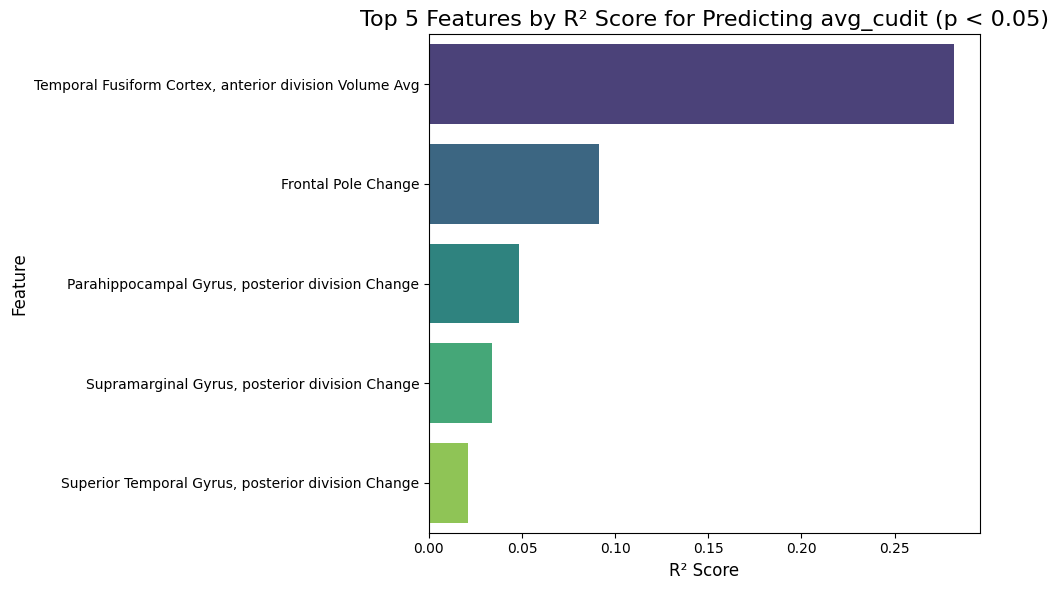

In [11]:
analysis.run_linear_regression()
analysis.plot_top_features()

Visualizing brain differences for subject 112...
Loading images...
Showing baseline and follow-up images...


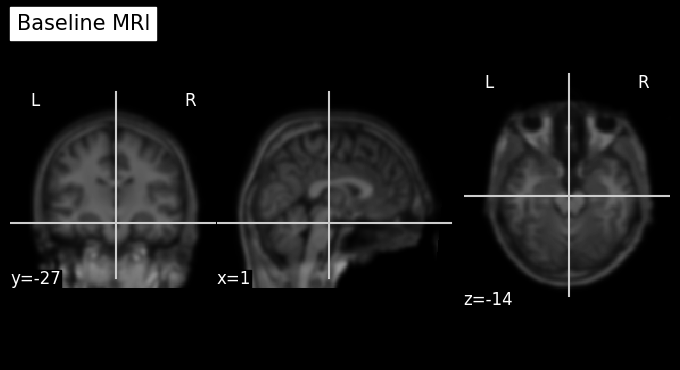

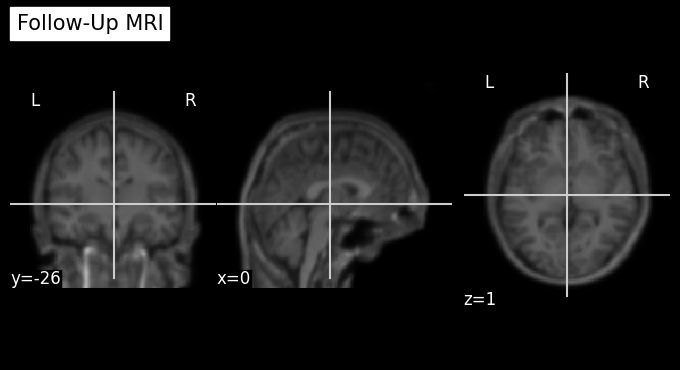

Showing simple difference map (coolwarm)...


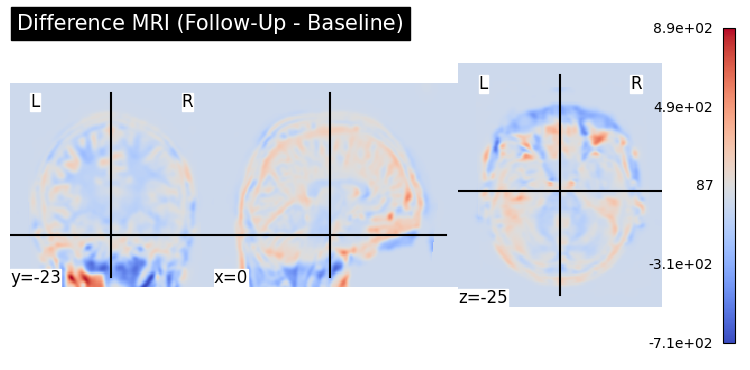

Showing glass brain visualization...


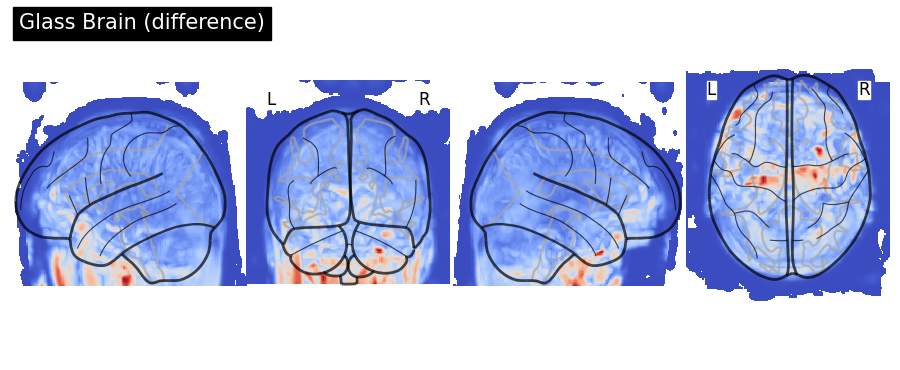

Attempting to create a spider chart of ROI-level changes...


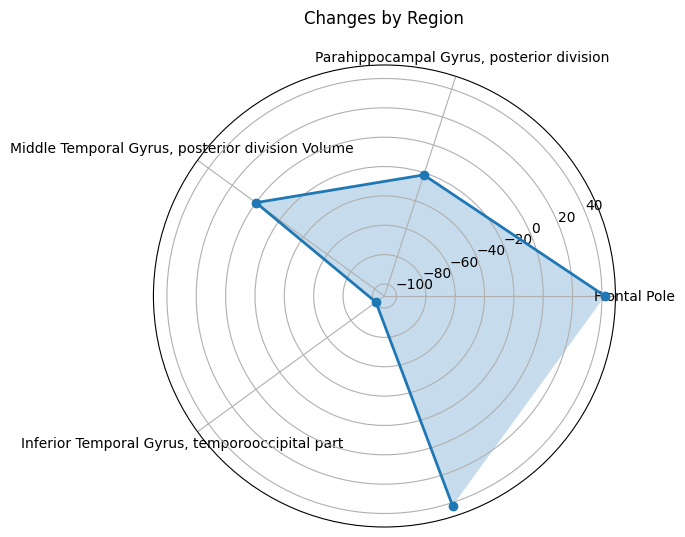

In [12]:
analysis.visualize_brain_differences(subject_id=112)

Training Random Forest model...
Random Forest R² Score: -0.0818


/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_51201/3987675268.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features['Importance'], y=top_10_features['Feature'], palette='coolwarm')


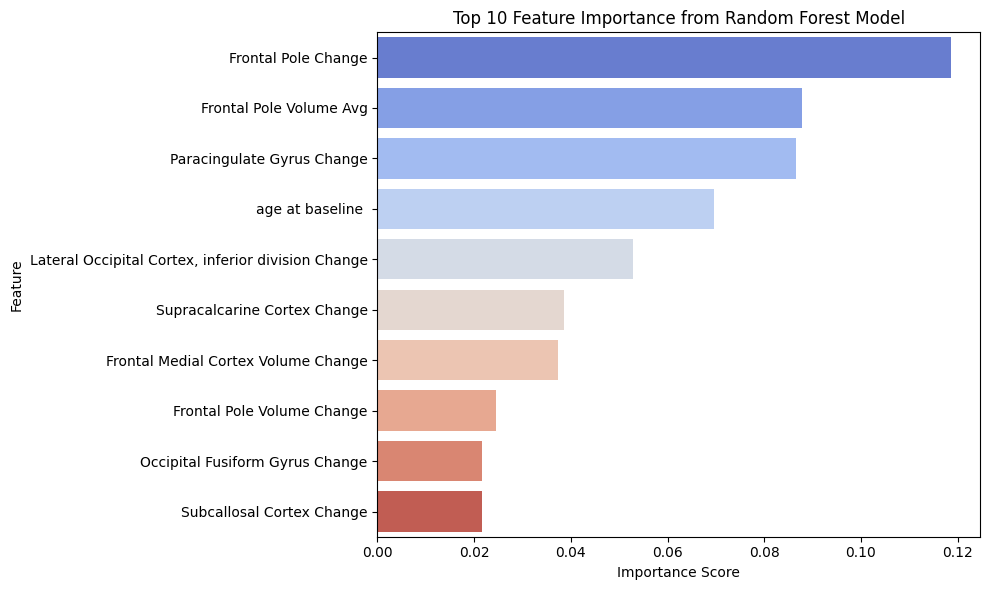

In [13]:
analysis.run_random_forest()

Visualizing brain differences for subject 303...


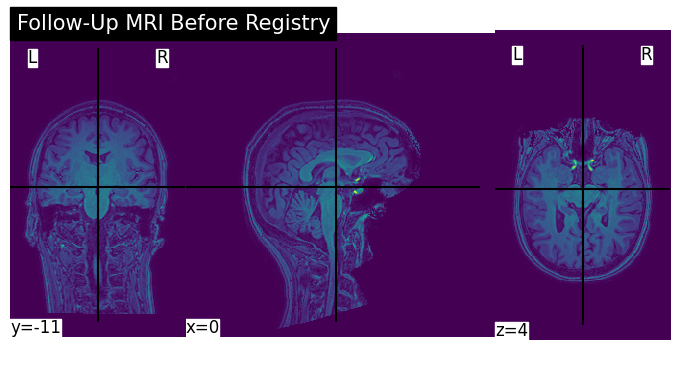

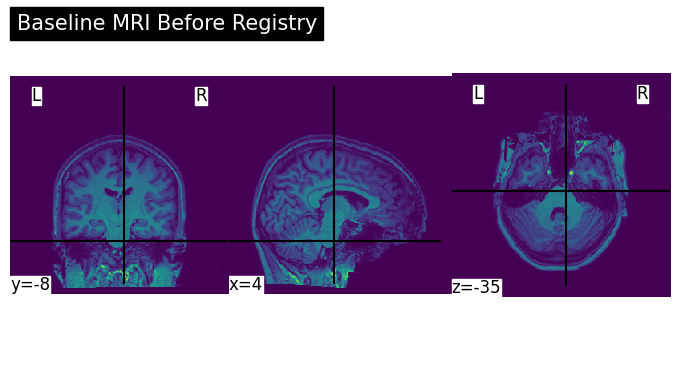

In [35]:
analysis.visualize_brain_differences_registry(subject_id=303)